# Azimuthal averaging in log-scaled bins

original author: Jerome Kieffer

PyFAI has been optimized for histogramming data on uniform bins. 
Neverthless one can perform this histogramming in a different space. 
This cookbook explains how to choose the proper radial unit. 

First of all we will generate an image with some realistic noise and integrate it. 
Then we will observe the effects of the output space and finally we will create our own output space.

## Guinier-like scatterer image

In [1]:
%matplotlib nbagg

In [2]:
#import ipympl
from matplotlib import pyplot as plt
import numpy

In [3]:
import pyFAI, pyFAI.azimuthalIntegrator
from pyFAI.gui import jupyter
det = pyFAI.detector_factory("Pilatus300k")
ai = pyFAI.azimuthalIntegrator.AzimuthalIntegrator(dist=7, detector=det)
ai.wavelength=1e-10
q = ai.array_from_unit(unit="q_A^-1")


C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
#Guinier-like scatterer
I = 1e6*numpy.exp(-q**2/2)
#Add some noise to make it look real
Y = numpy.random.poisson(I)

<IPython.core.display.Javascript object>


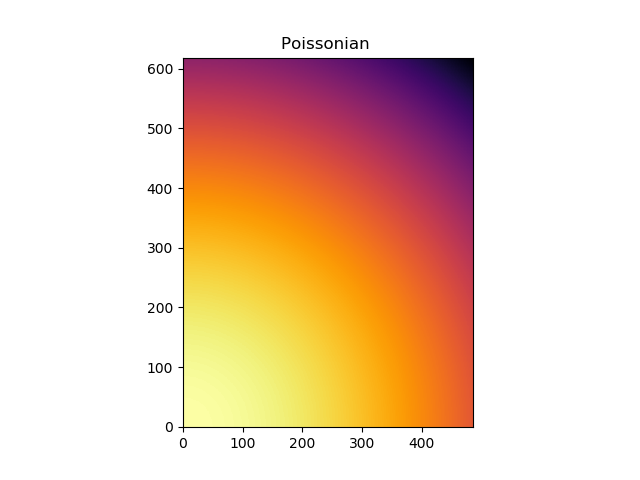

In [5]:
fig, ax = plt.subplots(1)
jupyter.display(I, ax=ax, label="Poissonian ")
fig.show()

<IPython.core.display.Javascript object>


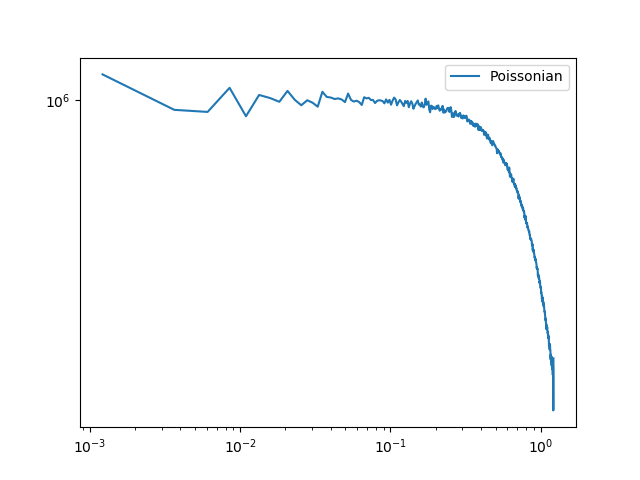

In [6]:
fig, ax = plt.subplots()
ax.plot(*ai.integrate1d(Y, 500), label="Poissonian")
ax.legend()
ax.loglog()
fig.show()

## Selection of the log-space rebinning

In this section we see how to switch to log-scale at the integration level (and revert back to q_nm^-1 for plotting).

PyFAI does not like negative radial units. Hence log(q) has to be prohibited. I would recommend the $arcsinh$ functions which is a well behaved function from R -> R with a slope at the origin of 1 and a log-scale behaviour.

<IPython.core.display.Javascript object>


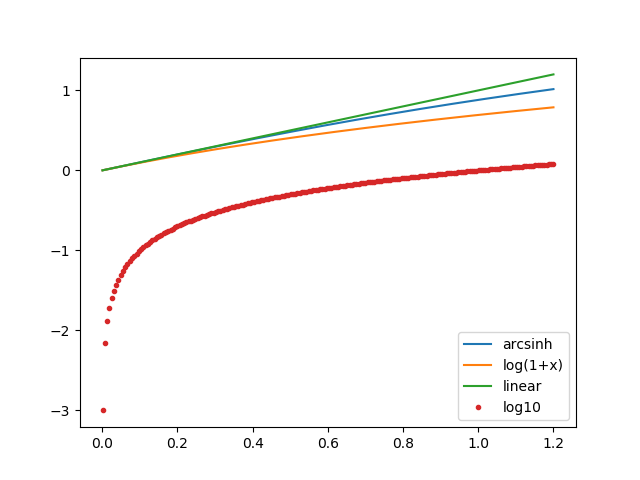

In [7]:
x = numpy.linspace(0.001, 1.2, 200)
fig, ax = plt.subplots()
ax.plot(x, numpy.arcsinh(x), label="arcsinh")
ax.plot(x, numpy.log1p(x), label="log(1+x)")
ax.plot(x, x, label="linear")
ax.plot(x, numpy.log10(x), ".", label ="log10")
ax.legend()
fig.show()

<IPython.core.display.Javascript object>


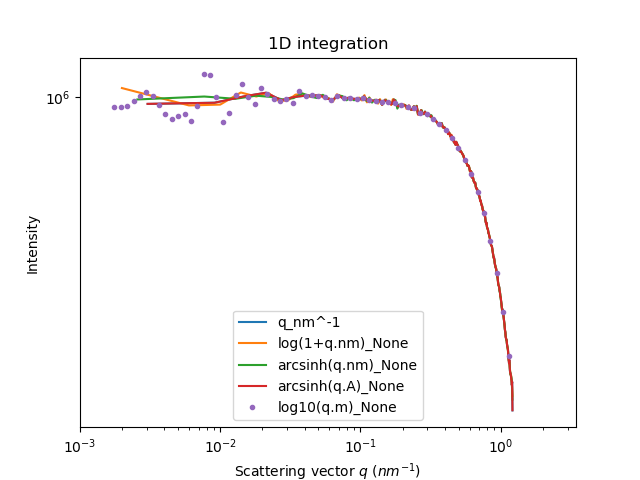

C:\Anaconda3\lib\site-packages\pyFAI\units.py:213: RuntimeWarning: divide by zero encountered in log10
  equation=lambda x, y, z, wavelength: numpy.log10(1e9 * eq_q(x, y, z, wavelength)))


In [8]:
fig, ax = plt.subplots()
method="splitpixel"
jupyter.plot1d(ai.integrate1d(Y, 200, method=method),ax=ax, label="q_nm^-1")
ax.loglog()
x,y = ai.integrate1d(Y, 200, unit="log(1+q.nm)_None", method=method)
ax.plot(numpy.exp(x)-1,y, label="log(1+q.nm)_None")
x,y = ai.integrate1d(Y, 200, unit="arcsinh(q.nm)_None", method=method)
ax.plot(numpy.sinh(x), y, label="arcsinh(q.nm)_None")
x,y = ai.integrate1d(Y, 200, unit="arcsinh(q.A)_None", method=method)
ax.plot(numpy.sinh(x)*10, y, label="arcsinh(q.A)_None")
x,y = ai.integrate1d(Y, 200, unit="log10(q.m)_None", method=method)
ax.plot(numpy.power(10, x)*1e-9, y, ".", label="log10(q.m)_None")

ax.set_xlim(1e-3)
ax.legend()
fig.show()

Going to log-scale helps to reduce the noise at high $q$ as on can see in the log(1+q.nm) or arcsinh(q.nm). 
The maximum value for $q$ is only 0.56${A}$, so after taking the log scale this remain in the linear part of the curve.
On the opposite, one would like to histogram on bins with larger numerical values. This is what we will see now. 

## Creation of a new radial unit

Let's create the $arcsinh(q.µm)$ unit. 
$q$ in inverse micrometer has numerical values 1000 times larger than in inverse nanometer, and should emphathize the curvature.

In [9]:
from pyFAI.units import eq_q, register_radial_unit

register_radial_unit("arcsinh(q.µm)_None",
                     scale=1.0,
                     label=r"arcsinh($q$.µm)",
                     equation=lambda x, y, z, wavelength: numpy.arcsinh(1000*eq_q(x, y, z, wavelength))) 



## Unexpected behavior
Here we will see, that 

1. Behavior of newly created radial unit "arcsinh(q,µm)_None" is not the same 
   like for "arcsinh(q.nm)_None" or "arcsinh(q.A)_None". 
   Distortion was expected but why range is not the same (big extension at lower q)?
2. At lower figure one can see that difference in using arcsinh(q.nm) vs "log(1+q.A) vs "q_nm^-1" is almost negligible.

<IPython.core.display.Javascript object>


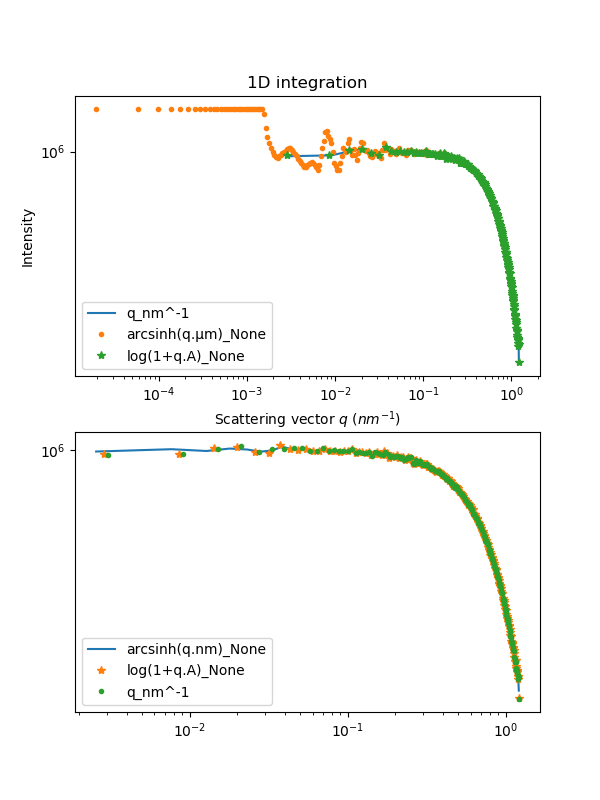

In [22]:
fig, ax = plt.subplots(2, figsize=(6,8))
method="splitpixel"
jupyter.plot1d(ai.integrate1d(Y, 200, method=method),ax=ax[0], label="q_nm^-1")
ax[0].loglog()
ax[1].loglog()
x,y = ai.integrate1d(Y, 200, unit="arcsinh(q.nm)_None", method=method)
#ax[0].plot(numpy.sinh(x), y, label="arcsinh(q.nm)_None")
ax[1].plot(numpy.sinh(x), y, label="arcsinh(q.nm)_None")
x,y = ai.integrate1d(Y, 200, unit="arcsinh(q.µm)_None", method=method)
ax[0].plot(numpy.sinh(x)/1000, y, ".", label="arcsinh(q.µm)_None")
x,y = ai.integrate1d(Y, 200, unit="log(1+q.A)_None", method=method)
ax[0].plot((numpy.exp(x)-1)*10, y, "*", label="log(1+q.A)_None")
ax[1].plot((numpy.exp(x)-1)*10, y, "*", label="log(1+q.A)_None")
x,y = ai.integrate1d(Y, 200, unit="q_nm^-1", method=method)
ax[1].plot(x, y, ".", label="q_nm^-1")

ax[0].legend()
ax[1].legend()

fig.show()

## Effect of radial_range
for simplicity let it make equal to our generated data.

Effect of different scale binning becomes even smaller.
Expected more points in the beginning with arcsinh, but it exactly the same like for "q_nm^-1". Difference is observed at higher q-range.

<IPython.core.display.Javascript object>


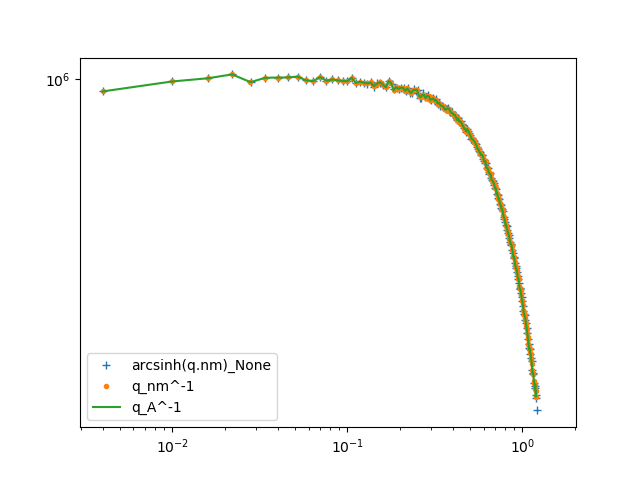

In [25]:
fig, ax = plt.subplots()
method="splitpixel"
qrange = (0.001, 1.2)
x,y =ai.integrate1d(Y, 200, radial_range=qrange, unit="arcsinh(q.nm)_None", method=method)
ax.plot(numpy.sinh(x), y, "+", label="arcsinh(q.nm)_None")
x,y =ai.integrate1d(Y, 200, radial_range=qrange, unit="q_nm^-1", method=method)
ax.plot(x, y, ".", label="q_nm^-1")
x,y =ai.integrate1d(Y, 200, radial_range=(0.0001, 0.12), unit="q_A^-1", method=method)
ax.plot(x*10, y, label="q_A^-1")
ax.loglog()
ax.legend()

fig.show()